### Churn Analysis

Churn refers to the ratio of the number of customers a business lost in a given period to the total number of customers. In this project, we will be analysis the customer churn of a financial organisation and train a model that can predict customer churn.

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

C:\Users\miloh\AppData\Local\Continuum\anaconda31\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('churn_modelling.csv')

In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Exploratory Data Analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [5]:
# Checking the number of customers the business has.
df.CustomerId.nunique()

10000

In [6]:
#dropping features that are not needful for our analysis
df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)

In [7]:
#Statistical description of the data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00


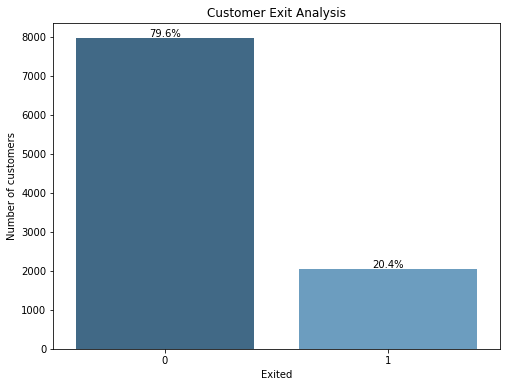

In [8]:
fig = plt.figure(figsize=(8,6));
ax = sns.countplot(x='Exited', data=df, palette='Blues_d')
plt.ylabel('Number of customers')
plt.title('Customer Exit Analysis')       
    
# Setting percentage
total = len(df['Exited'])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]

    ax.annotate(percentage, (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
plt.show()   

> Of the 10000 customers, about 20% exited the company

In [9]:
df.groupby('Exited').mean()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
Exited,,,,,,,,
0,651.853196,37.408389,5.033279,72745.296779,1.544267,0.707146,0.554565,99738.391772
1,645.351497,44.837997,4.932744,91108.539337,1.475209,0.699067,0.360825,101465.677531


> From the table above, there appears to be a major difference between customers that exited and those that did not in terms of age, balance, active membership and number of products. Let's explore further

In [10]:
# Age Feature Enhancement
age_labels = ['18-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']
Age_group = pd.cut(df['Age'], range(10, 101, 10), right=False, labels=age_labels)
df['Age_grp'] = Age_group

In [11]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Age_grp
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,41-50
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,41-50
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,41-50
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,31-40
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,41-50


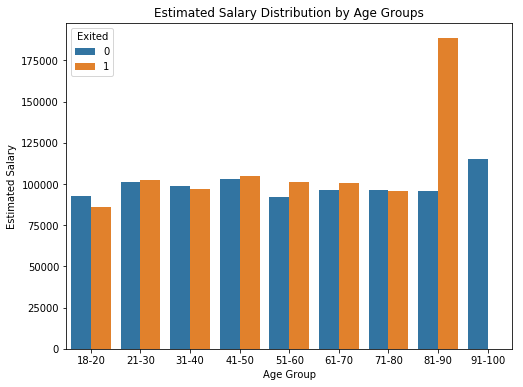

In [12]:
#color = sns.color_palette()[0]
fig = plt.figure(figsize=(8,6));
sns.barplot('Age_grp', 'EstimatedSalary', data = df, hue = 'Exited', ci = None)
plt.title("Estimated Salary Distribution by Age Groups",fontsize=12)
plt.ylabel('Estimated Salary')
plt.xlabel('Age Group');

> Although age does not significantly inform a customer's churn decision, it can be seen here that customers with more earnings tends to exit. It can be suggested that the more income a customer earns, the tendency to depend on the bank services for example loans becomes reduced.

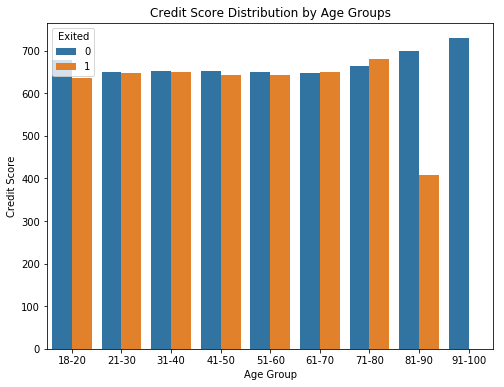

In [13]:
fig = plt.figure(figsize=(8,6))
sns.barplot('Age_grp', 'CreditScore', data = df, hue = 'Exited', ci = None)
plt.title("Credit Score Distribution by Age Groups",fontsize=12)
plt.ylabel('Credit Score')
plt.xlabel('Age Group');

> Generally, the customers has good credit standing. The credit score has no significant impact on customer churn.

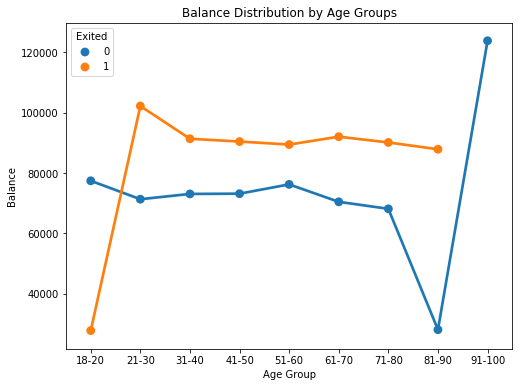

In [14]:
fig = plt.figure(figsize=(8,6))
sns.pointplot('Age_grp', 'Balance', data = df, hue = 'Exited', ci = None)
plt.title("Balance Distribution by Age Groups",fontsize=12)
plt.ylabel('Balance')
plt.xlabel('Age Group');

> Customers with higher balance in their account are more prone to exit.

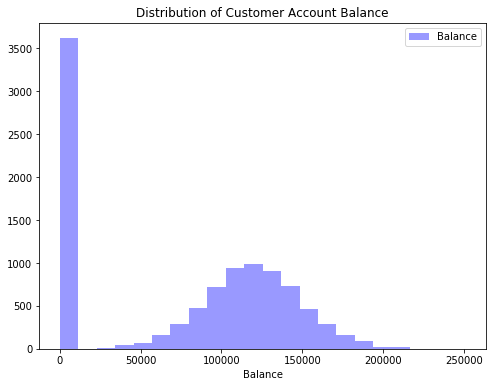

In [15]:
fig = plt.figure(figsize=(8,6))
sns.distplot(df.Balance, color="blue", label="Balance", kde=False)
plt.legend()
plt.title('Distribution of Customer Account Balance');

> There are substantial amount of customers with no zero balance in their account

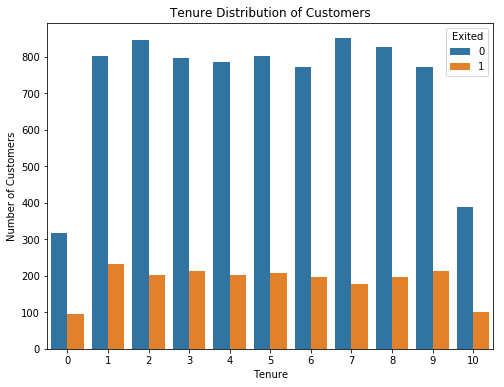

In [16]:
fig = plt.figure(figsize=(8,6))
sns.countplot('Tenure', data = df, hue = 'Exited')
plt.title("Tenure Distribution of Customers",fontsize=12)
plt.ylabel('Number of Customers');
#plt.xlabel('Age Group');

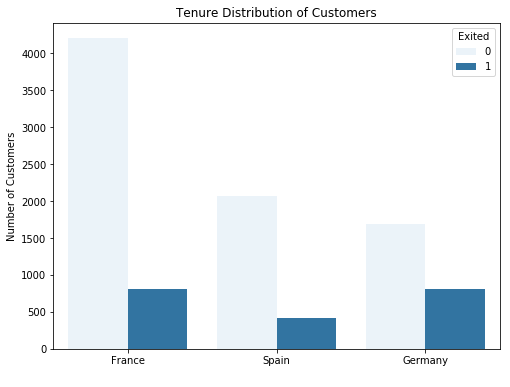

In [17]:
color = sns.color_palette()[0]
plt.figure(figsize=(8,6))
sns.countplot('Geography', data = df, hue = 'Exited', color = color)
plt.title("Tenure Distribution of Customers",fontsize=12)
plt.ylabel('Number of Customers');
plt.xlabel(' ');

> The bank has more customers from France and lowest from Spain. However, German customers has the highest churn rate.

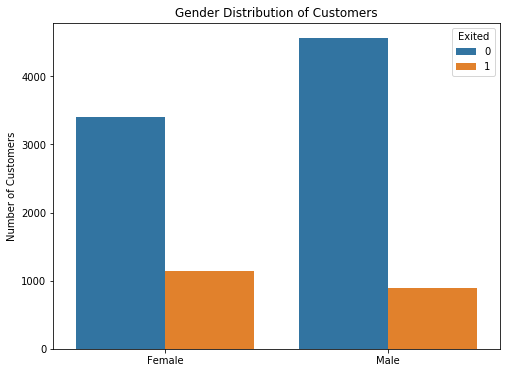

In [18]:
fig = plt.figure(figsize=(8,6))
sns.countplot('Gender', data = df, hue = 'Exited')
plt.title("Gender Distribution of Customers",fontsize=12)
plt.ylabel('Number of Customers');
plt.xlabel(' ');

> Although the bank has more male customers, female Customers are more prone to exit

### Data Preprocessing

In [19]:
#One hot encoding of categorical features
df_geo = pd.get_dummies(df['Geography'], columns= df.Geography[0], dtype= 'int64')
df_gender = pd.get_dummies(df['Gender'], columns= df.Gender[0], dtype= 'int64')

In [20]:
df = df.join(df_geo)
df = df.join(df_gender)

In [21]:
#drop the unneeded columns
df.drop('Geography', axis = 1, inplace = True)
df.drop('Gender', axis = 1, inplace = True)
df.drop('Age_grp', axis = 1, inplace = True)

In [22]:
df

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,Germany,Spain,Female,Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,0,1,0,0,0,1
9996,516,35,10,57369.61,1,1,1,101699.77,0,1,0,0,0,1
9997,709,36,7,0.00,1,0,1,42085.58,1,1,0,0,1,0
9998,772,42,3,75075.31,2,1,0,92888.52,1,0,1,0,0,1


In [23]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [24]:
columns = ['CreditScore', 'Balance', 'EstimatedSalary']
for col in columns:
    column = scaler.fit_transform(df[col].values.reshape(-1, 1))
    df[col] = pd.DataFrame(data=column, columns=[col])

In [25]:
df

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,Germany,Spain,Female,Male
0,0.538,42,2,0.000000,1,1,1,0.506735,1,1,0,0,1,0
1,0.516,41,1,0.334031,1,0,1,0.562709,0,0,0,1,1,0
2,0.304,42,8,0.636357,3,1,0,0.569654,1,1,0,0,1,0
3,0.698,39,1,0.000000,2,0,0,0.469120,0,1,0,0,1,0
4,1.000,43,2,0.500246,1,1,1,0.395400,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.842,39,5,0.000000,2,1,0,0.481341,0,1,0,0,0,1
9996,0.332,35,10,0.228657,1,1,1,0.508490,0,1,0,0,0,1
9997,0.718,36,7,0.000000,1,0,1,0.210390,1,1,0,0,1,0
9998,0.844,42,3,0.299226,2,1,0,0.464429,1,0,1,0,0,1


In [26]:
#Create training and testing sets
from sklearn.model_selection import train_test_split

y = df.loc[:,'Exited']
X = df.drop('Exited', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
len(y_train), len(y_test)

(8000, 2000)

In [28]:
X_train

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,France,Germany,Spain,Female,Male
9254,0.672,32,6,0.000000,2,1,1,0.895494,1,0,0,0,1
1561,0.564,42,4,0.476786,2,1,1,0.979930,0,1,0,0,1
1670,0.418,24,3,0.457317,1,1,0,0.429438,0,0,1,0,1
6087,0.422,27,9,0.540606,1,1,0,0.765417,1,0,0,1,0
6669,0.334,56,9,0.566554,1,0,0,0.197401,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,0.836,54,8,0.277853,1,1,1,0.346880,1,0,0,0,1
5191,0.664,58,1,0.000000,1,1,1,0.003475,1,0,0,1,0
5390,0.770,38,1,0.000000,3,0,0,0.461087,1,0,0,1,0
860,0.634,43,8,0.758186,1,1,0,0.487529,1,0,0,0,1


### Model Training

In [27]:
models = [LogisticRegression(),
          SGDClassifier(loss="perceptron", eta0=1, learning_rate="constant", penalty=None, random_state=0),
          GaussianNB(),
          RandomForestClassifier(n_estimators=100, max_features='sqrt'),
          KNeighborsClassifier(n_neighbors=30),
          DecisionTreeClassifier(random_state=0),
          #CatBoostClassifier(verbose=0, n_estimators=100),
          XGBClassifier(),
          SVC(gamma='auto')
          ]

TestModels = pd.DataFrame()
tmp = {}

for model in models:
    m = str(model)
    tmp['Model'] = m[:m.index('(')]
    model.fit(X_train, y_train)
    
    # Get predictions
    y_preds = model.predict(X_test)
    
    tmp['Score'] = accuracy_score(y_test, y_preds)
    print(tmp)
    TestModels = TestModels.append(tmp, ignore_index=True)

NameError: name 'LogisticRegression' is not defined

In [ ]:
TestModels

In [ ]:
X_train.columns

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

model.fit(X_train, y_train)

# Get predictions
y_preds = model.predict(X_test)

from sklearn.externals import joblib

joblib.dump(model, 'export/1/model.joblib')

In [ ]:
!pip uninstall scikit-learn

In [ ]:
!pip install scikit-learn==0.23.2

In [ ]:
import sckit-learn
sklearn.__version__

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_preds)

In [ ]:
#Adding cateboost classifier 
model = CatBoostClassifier(verbose=0, n_estimators=100)
model.fit(X_train, y_train)

# Get predictions
y_preds = model.predict(X_test)

tmp['Model'] = 'CatBoost'
tmp['Score'] = accuracy_score(y_test, y_preds)
TestModels = TestModels.append(tmp, ignore_index=True)

#import pickle
#s = pickle.dumps(model)

In [ ]:
TestModels

> From the table above, **Catboost classifier** model is the best model with accuracy score of **87%**.

In [29]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential

In [30]:
model = Sequential()
model.add(Dense(13, input_dim=13, kernel_initializer='orthogonal', activation='softplus'))
model.add(Dense(8, kernel_initializer='orthogonal', activation='softplus'))
model.add(Dense(4, kernel_initializer='orthogonal', activation='softplus'))
model.add(Dense(1, kernel_initializer='orthogonal', activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [31]:
model.fit(X_train, y_train, epochs=250, batch_size= 200)

Train on 8000 samples
Epoch 1/250
8000/8000 [==============================] - 0s 32us/sample - loss: 1.0112 - accuracy: 0.7945
Epoch 2/250
8000/8000 [==============================] - 0s 9us/sample - loss: 0.5664 - accuracy: 0.7945
Epoch 3/250
8000/8000 [==============================] - 0s 10us/sample - loss: 0.5242 - accuracy: 0.7945
Epoch 4/250
8000/8000 [==============================] - 0s 11us/sample - loss: 0.4770 - accuracy: 0.7941
Epoch 5/250
8000/8000 [==============================] - 0s 10us/sample - loss: 0.4497 - accuracy: 0.7969
Epoch 6/250
8000/8000 [==============================] - 0s 10us/sample - loss: 0.4405 - accuracy: 0.8037
Epoch 7/250
8000/8000 [==============================] - 0s 10us/sample - loss: 0.4391 - accuracy: 0.8065
Epoch 8/250
8000/8000 [==============================] - 0s 10us/sample - loss: 0.4352 - accuracy: 0.8099
Epoch 9/250
8000/8000 [==============================] - 0s 10us/sample - loss: 0.4339 - accuracy: 0.8123
Epoch 10/250
8000/8000 [=

8000/8000 [==============================] - 0s 15us/sample - loss: 0.4009 - accuracy: 0.8351
Epoch 77/250
8000/8000 [==============================] - 0s 13us/sample - loss: 0.3991 - accuracy: 0.8367
Epoch 78/250
8000/8000 [==============================] - 0s 13us/sample - loss: 0.3975 - accuracy: 0.8354
Epoch 79/250
8000/8000 [==============================] - 0s 15us/sample - loss: 0.3971 - accuracy: 0.8371
Epoch 80/250
8000/8000 [==============================] - 0s 11us/sample - loss: 0.3975 - accuracy: 0.8371
Epoch 81/250
8000/8000 [==============================] - 0s 10us/sample - loss: 0.3945 - accuracy: 0.8395
Epoch 82/250
8000/8000 [==============================] - 0s 12us/sample - loss: 0.3945 - accuracy: 0.8394
Epoch 83/250
8000/8000 [==============================] - 0s 9us/sample - loss: 0.3930 - accuracy: 0.8400
Epoch 84/250
8000/8000 [==============================] - 0s 10us/sample - loss: 0.3933 - accuracy: 0.8406
Epoch 85/250
8000/8000 [===========================

Epoch 152/250
8000/8000 [==============================] - 0s 9us/sample - loss: 0.3440 - accuracy: 0.8599
Epoch 153/250
8000/8000 [==============================] - 0s 9us/sample - loss: 0.3458 - accuracy: 0.8581
Epoch 154/250
8000/8000 [==============================] - 0s 10us/sample - loss: 0.3424 - accuracy: 0.8595
Epoch 155/250
8000/8000 [==============================] - 0s 10us/sample - loss: 0.3419 - accuracy: 0.8584
Epoch 156/250
8000/8000 [==============================] - 0s 10us/sample - loss: 0.3448 - accuracy: 0.8565
Epoch 157/250
8000/8000 [==============================] - 0s 7us/sample - loss: 0.3438 - accuracy: 0.8604
Epoch 158/250
8000/8000 [==============================] - 0s 8us/sample - loss: 0.3429 - accuracy: 0.8580
Epoch 159/250
8000/8000 [==============================] - 0s 9us/sample - loss: 0.3408 - accuracy: 0.8591
Epoch 160/250
8000/8000 [==============================] - 0s 9us/sample - loss: 0.3402 - accuracy: 0.8601
Epoch 161/250
8000/8000 [=========

In [42]:
loss, acc = model.evaluate(X_test, y_test, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

print(model.predict(X_test))

2000/2000 - 0s - loss: 0.3378 - accuracy: 0.8615
Restored model, accuracy: 86.15%
[[0.05832893]
 [0.04160401]
 [0.1603668 ]
 ...
 [0.75239   ]
 [0.14242283]
 [0.35848072]]


In [39]:
X_test.tail(3)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,France,Germany,Spain,Female,Male
7853,0.760,47,7,0.000000,1,1,0,0.166824,1,0,0,1,0
1095,0.684,29,4,0.000000,1,1,0,0.383759,1,0,0,0,1
6929,0.556,39,1,0.459713,1,1,1,0.538365,0,1,0,0,1


In [36]:
y_test

6252    0
4684    0
1731    0
4742    0
4521    0
       ..
6412    1
8285    0
7853    1
1095    1
6929    1
Name: Exited, Length: 2000, dtype: int64

In [ ]:
# Save the entire model as a SavedModel.
model.save("model.h5")

In [ ]:
# create model from saved model
model_loaded = tf.keras.models.load_model('model.h5')

In [ ]:
# generate summary
model_loaded.summary()

In [ ]:
# export model
tf.keras.models.save_model(model, "export/", include_optimizer=True)

In [ ]:
from sklearn.externals import joblib
#from joblib import dump, load
joblib.dump(model, 'churn_model.joblib')